# Representation Analysis

In [22]:
import sys

#@markdown Execute this cell to import third-party software into the Colab environment.

# check whether it runs in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install timm==0.5.4
    !pip3 install matplotlib==3.7.1
    !pip3 install scikit-learn==1.2.2
    !pip3 install fastai==2.7.12
    !pip3 install einops==0.6.0
    !pip3 install gdown==4.7.1
    !pip3 install yacs==0.1.8    
    !git clone https://github.com/naver-ai/cl-vs-mim.git
    root = "./cl-vs-mim"
    %cd $root

In [23]:
import torch

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.7.1+cu118 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x0000025556AD3DF0> 
Device name: NVIDIA GeForce RTX 2070


In [24]:
# Cell: Fixed Dataset Loading with Better Subsampling
import os
import math
import numpy as np
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from utils import subsample

DATASET = "flowers102"  # @param ["cifar100", "flowers102"]
METHOD = "pretrained"       # @param ["full", "lora", "adaptformer", "bitfit"]

# Dataset configurations
dataset_configs = {
    "cifar100": {
        "num_classes": 100,
        "data_dir": "./data/cifar-100-python",
        "mean": [0.485, 0.456, 0.406],
        "std": [0.229, 0.224, 0.225]
    },
    "flowers102": {
        "num_classes": 102,
        "data_dir": "./data/flowers102",
        "mean": [0.485, 0.456, 0.406], 
        "std": [0.229, 0.224, 0.225]
    }
}

config = dataset_configs[DATASET]

# Transform for analysis
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(config["mean"], config["std"])
])

# Load dataset with proper handling
dataset_test = None

if DATASET == "cifar100":
    dataset_test = datasets.CIFAR100(
        root=config["data_dir"], 
        train=False, 
        download=True, 
        transform=transform_test
    )
    print(f"CIFAR-100 dataset loaded: {len(dataset_test)} images")
    
elif DATASET == "flowers102":
    # Use the path we know works
    test_dir = "./data/flowers102/dataset/valid"
    try:
        dataset_test = datasets.ImageFolder(test_dir, transform=transform_test)
        print(f"Using {test_dir}: {len(dataset_test)} images")
    except Exception as e:
        print(f"Error loading {test_dir}: {e}")

# Create DataLoader if dataset was loaded successfully
if dataset_test is not None:
    # Better subsampling - use a larger ratio or fixed number
    original_size = len(dataset_test)
    
    # For analysis, we want at least 200-500 samples
    if original_size > 500:
        # Use a ratio that gives us ~300 samples
        target_samples = 300
        subsample_ratio = target_samples / original_size
    else:
        # Use all samples if dataset is small
        subsample_ratio = 1.0
    
    print(f"Using subsample ratio: {subsample_ratio:.3f}")
    
    if subsample_ratio < 1.0:
        subsample_indices = subsample(dataset_test, ratio=subsample_ratio)
        dataset_test = torch.utils.data.Subset(dataset_test, subsample_indices)
        print(f"Subsampled from {original_size} to {len(dataset_test)} images")
    else:
        print(f"Using all {original_size} images")
    
    # Create DataLoader with smaller batch size for analysis
    dataset_test = DataLoader(dataset_test, num_workers=0, batch_size=8, shuffle=False)
    
    # Test the DataLoader
    try:
        test_batch = next(iter(dataset_test))
        print(f"DataLoader working - batch shape: {test_batch[0].shape}")
        # Reset iterator
        dataset_test = DataLoader(torch.utils.data.Subset(dataset_test.dataset, 
                                                         list(range(len(dataset_test.dataset)))), 
                                 num_workers=0, batch_size=8, shuffle=False)
    except StopIteration:
        print("DataLoader is empty")
        dataset_test = None
    except Exception as e:
        print(f"DataLoader error: {e}")
        dataset_test = None
else:
    print("No valid dataset found")
    
print(f"Final status - Dataset: {'Ready' if dataset_test else '❌ None'}")

Using ./data/flowers102/dataset/valid: 1020 images
Using subsample ratio: 0.294
Subsampled from 1020 to 204 images
DataLoader working - batch shape: torch.Size([8, 3, 224, 224])
Final status - Dataset: Ready


## Load the Models

In [ ]:
import torch
from transformers import ViTForImageClassification
from models.lora_vit import apply_lora_to_vit
from models.adapt_former import apply_adaptformer_to_vit  # Uncomment this
from models.bitfit_vit import apply_bitfit_to_vit          # Uncomment this

def load_finetuned_model(checkpoint_path, dataset_name, method="full"):
    """Load a fine-tuned model from checkpoint"""
    
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
    
    # Get number of classes
    num_classes_map = {"cifar10": 10, "cifar100": 100, "flowers102": 102}
    num_classes = num_classes_map[dataset_name]
    
    try:
        # Create base model - ADD output flags for analysis
        model = ViTForImageClassification.from_pretrained(
            "facebook/dino-vits16",
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
            output_attentions=True,      # Add this for attention analysis
            output_hidden_states=True    # Add this for representation analysis
        )
        
        # Apply fine-tuning method BEFORE loading checkpoint
        if method == "lora":
            apply_lora_to_vit(model, r=8, alpha=16, dropout=0.1)
        elif method == "bitfit":
            # BitFit is applied after loading
            pass
        elif method == "adaptformer":
            apply_adaptformer_to_vit(model, bottleneck_dim=64)  # Add this
        # elif method == "full": no additional setup needed
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Apply BitFit after loading (only changes requires_grad)
        if method == "bitfit":
            apply_bitfit_to_vit(model, verbose=False)
        
        model = model.cuda()
        model = model.eval()
        
        print(f"Loaded: {dataset_name}_{method}")
        return model
        
    except Exception as e:
        print(f"Error loading {checkpoint_path}: {e}")
        return None

def load_pretrained_dino(dataset_name):
    """Load the original pre-trained DINO model for comparison"""
    try:
        # Get number of classes for the dataset
        num_classes_map = {"cifar10": 10, "cifar100": 100, "flowers102": 102}
        num_classes = num_classes_map[dataset_name]
        
        # Load pre-trained DINO model
        model = ViTForImageClassification.from_pretrained(
            "facebook/dino-vits16",
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
            output_attentions=True,
            output_hidden_states=True
        )
        
        model = model.cuda().eval()
        print(f"Loaded pre-trained DINO for {dataset_name}")
        return model
        
    except Exception as e:
        print(f"Error loading pre-trained DINO: {e}")
        return None

# Load all available models
models = {}
methods = ["full", "lora", "bitfit", "adaptformer"]
datasets = ["cifar100", "flowers102"]

print("🔍 Testing model loading...")
for dataset in datasets:
    for method in methods:
        checkpoint_path = f"./checkpoints/{dataset}/{method}/best_checkpoint_{dataset}_{method}.pth"
        model_key = f"{dataset}_{method}"
        models[model_key] = load_finetuned_model(checkpoint_path, dataset, method)
    
    # Add pre-trained DINO for each dataset
    print(f"Loading pre-trained DINO for {dataset}...")
    pretrained_dino = load_pretrained_dino(dataset)
    if pretrained_dino is not None:
        dino_key = f"{dataset}_pretrained"
        models[dino_key] = pretrained_dino
        print(f"Added pre-trained DINO: {dino_key}")

# Filter out None models
available_models = {k: v for k, v in models.items() if v is not None}
print(f"\nAvailable models: {list(available_models.keys())}")

# Load the selected model for analysis - Updated to handle pretrained
if METHOD == "pretrained":
    current_model_key = f"{DATASET}_pretrained"
else:
    current_model_key = f"{DATASET}_{METHOD}"

if current_model_key in available_models:
    selected_model = available_models[current_model_key]
    print(f"Selected for analysis: {current_model_key}")
else:
    print(f"Selected model {current_model_key} not available")
    # Use fallback if available
    if available_models:
        fallback_key = list(available_models.keys())[0]
        selected_model = available_models[fallback_key]
        print(f"🔄 Using fallback: {fallback_key}")
    else:
        selected_model = None
        print("No models available")

🔍 Testing model loading...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded: cifar100_full


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model structure before LoRA:
Module: vit
Module: vit.embeddings
Module: vit.embeddings.patch_embeddings
Module: vit.encoder
Module: vit.encoder.layer
Linear layer: classifier -> in:384, out:100
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Ap

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded: cifar100_bitfit


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdaptFormer applied
✅ Loaded: cifar100_adaptformer
🔍 Loading pre-trained DINO for cifar100...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded pre-trained DINO for cifar100
📋 Added pre-trained DINO: cifar100_pretrained


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded: flowers102_full


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model structure before LoRA:
Module: vit
Module: vit.embeddings
Module: vit.embeddings.patch_embeddings
Module: vit.encoder
Module: vit.encoder.layer
Linear layer: classifier -> in:384, out:102
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: dense
Applying LoRA to: query
Applying LoRA to: key
Applying LoRA to: value
Applying LoRA to: dense
Ap

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded: flowers102_bitfit


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AdaptFormer applied
✅ Loaded: flowers102_adaptformer
🔍 Loading pre-trained DINO for flowers102...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded pre-trained DINO for flowers102
📋 Added pre-trained DINO: flowers102_pretrained

📋 Available models: ['cifar100_full', 'cifar100_lora', 'cifar100_bitfit', 'cifar100_adaptformer', 'cifar100_pretrained', 'flowers102_full', 'flowers102_lora', 'flowers102_bitfit', 'flowers102_adaptformer', 'flowers102_pretrained']
🎯 Selected for analysis: flowers102_pretrained


In [26]:
# Cell: Analysis Wrapper - Enhanced with Debug Info
def create_analysis_wrapper(model):
    """Wrap the fine-tuned model to match expected interface"""
    def wrapped_forward(x):
        print(f"Forward pass input shape: {x.shape}")
        
        # Get model outputs
        with torch.no_grad():
            outputs = model(pixel_values=x, output_attentions=True, output_hidden_states=True)
        
        # Extract what we need
        logits = outputs.logits
        hidden_states = outputs.hidden_states  # All layer outputs
        attentions = outputs.attentions
        
        print(f"Hidden states: {len(hidden_states) if hidden_states else 0} layers")
        if hidden_states:
            for i, hs in enumerate(hidden_states):
                if hs is not None:
                    print(f"   Layer {i}: {hs.shape}")
        
        # Format for analysis (mimic original interface)
        zs = list(hidden_states) if hidden_states else []
        
        # Handle attentions safely
        if attentions is not None and len(attentions) > 0 and attentions[0] is not None:
            attns = list(attentions)
        else:
            attns = [None] * len(zs)
        
        attn_fts = [None] * len(zs)
        
        return logits, zs, attns, attn_fts
    
    model.forward_analysis = wrapped_forward
    return model

# Wrap the selected model
if selected_model is not None:
    wrapped_model = create_analysis_wrapper(selected_model)
    print(f"Model wrapped for analysis: {DATASET}_{METHOD}")
else:
    wrapped_model = None
    print("No model available for analysis")

Model wrapped for analysis: flowers102_pretrained


## Fourier Analysis

Running Fourier Analysis for flowers102_pretrained...
Processing batch 1, input shape: torch.Size([8, 3, 224, 224])
Forward pass input shape: torch.Size([8, 3, 224, 224])
Hidden states: 13 layers
   Layer 0: torch.Size([8, 197, 384])
   Layer 1: torch.Size([8, 197, 384])
   Layer 2: torch.Size([8, 197, 384])
   Layer 3: torch.Size([8, 197, 384])
   Layer 4: torch.Size([8, 197, 384])
   Layer 5: torch.Size([8, 197, 384])
   Layer 6: torch.Size([8, 197, 384])
   Layer 7: torch.Size([8, 197, 384])
   Layer 8: torch.Size([8, 197, 384])
   Layer 9: torch.Size([8, 197, 384])
   Layer 10: torch.Size([8, 197, 384])
   Layer 11: torch.Size([8, 197, 384])
   Layer 12: torch.Size([8, 197, 384])
Got 13 layers from model
Valid layers: 12
Processing 12 latent layers
Updated Fourier latents: torch.Size([12, 7])
Processing batch 2, input shape: torch.Size([8, 3, 224, 224])
Forward pass input shape: torch.Size([8, 3, 224, 224])
Hidden states: 13 layers
   Layer 0: torch.Size([8, 197, 384])
   Layer 1: 

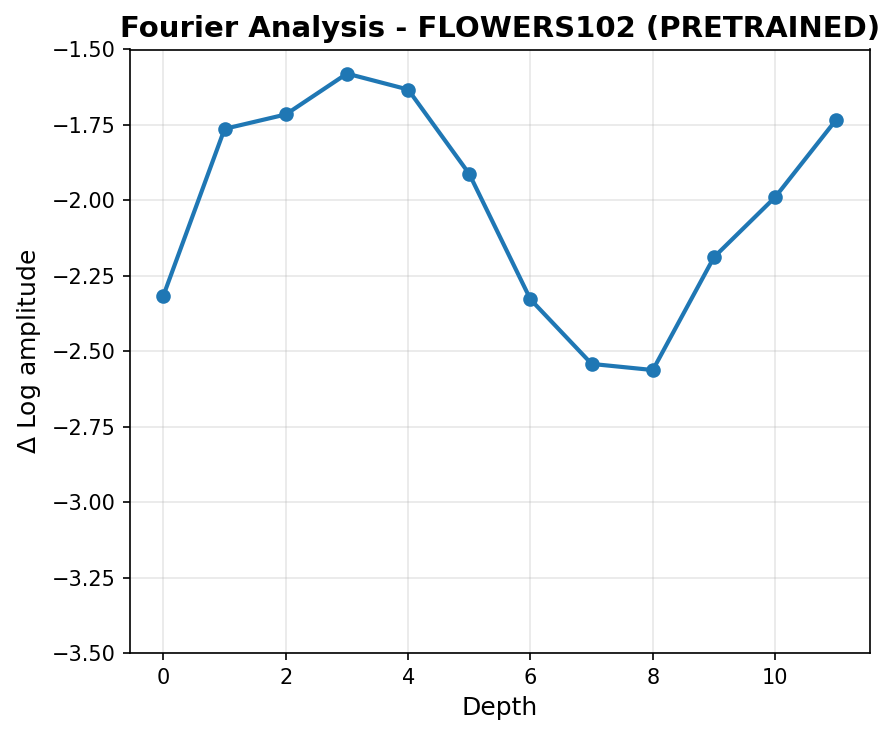

In [27]:
# Cell: Fourier Analysis - Fixed with Better Error Handling
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        
        if h * w != n:
            print(f"Non-square patch arrangement: {n} patches, expecting {h}x{w}={h*w}")
            continue
            
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]
        latent = latent - latent[0]
        fourier_latents.append(latent)
    return fourier_latents

# Run Fourier analysis with better error handling
if wrapped_model is not None and dataset_test is not None:
    print(f"Running Fourier Analysis for {DATASET}_{METHOD}...")
    
    fourier_latents = AverageMeter()
    batch_count = 0
    
    for i, (xs, ys) in enumerate(dataset_test):
        try:
            print(f"Processing batch {i+1}, input shape: {xs.shape}")
            
            with torch.no_grad():
                xs = xs.cuda()
                _, zs, _, _ = wrapped_model.forward_analysis(xs)
                
            print(f"Got {len(zs)} layers from model")
            
            # Remove final classification layer and filter valid layers
            valid_zs = [z for z in zs[:-1] if z is not None]
            print(f"Valid layers: {len(valid_zs)}")
            
            if valid_zs:
                # Remove CLS token
                latents = [z[:,1:,:] for z in valid_zs]
                print(f"Processing {len(latents)} latent layers")
                
                _fourier_latents = get_fourier_latents(latents)
                
                if _fourier_latents:
                    fourier_tensor = torch.stack(_fourier_latents)
                    fourier_latents.update(fourier_tensor)
                    print(f"Updated Fourier latents: {fourier_tensor.shape}")
                else:
                    print("No valid Fourier latents from this batch")
            else:
                print("No valid hidden states in this batch")
            
            batch_count += 1
            if batch_count >= 3:  # Process a few batches
                break
                
        except Exception as e:
            print(f"Error processing batch {i}: {e}")
            continue
    
    # Plot results
    if fourier_latents.count > 0:
        print(f"Plotting Fourier analysis from {fourier_latents.count} batches")
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
        fourier_avg = fourier_latents.avg
        
        print(f"Fourier average shape: {fourier_avg.shape}")
        
        ax.plot(range(len(fourier_avg)), fourier_avg[:,-1], marker="o", linewidth=2, markersize=6)
        ax.set_xlabel("Depth", fontsize=12)
        ax.set_ylabel("$\Delta$ Log amplitude", fontsize=12)
        ax.set_title(f"Fourier Analysis - {DATASET.upper()} ({METHOD.upper()})", fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(top=-1.5, bottom=-3.5)
        plt.tight_layout()
        plt.show()
    else:
        print("No Fourier data collected - check model and dataset")
else:
    print("Cannot run Fourier analysis - missing model or dataset")

## Toekn-level t-SNE Visualization

Running t-SNE Analysis for flowers102_pretrained...


C:\Users\rasmu\AppData\Local\Temp\ipykernel_376\1009362425.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def visualize_token_tsne(ax, zs, depth, ys, title="", cmap=cm.get_cmap("plasma")):


Got batch - xs: torch.Size([8, 3, 224, 224]), ys: 8
Forward pass input shape: torch.Size([8, 3, 224, 224])
Hidden states: 13 layers
   Layer 0: torch.Size([8, 197, 384])
   Layer 1: torch.Size([8, 197, 384])
   Layer 2: torch.Size([8, 197, 384])
   Layer 3: torch.Size([8, 197, 384])
   Layer 4: torch.Size([8, 197, 384])
   Layer 5: torch.Size([8, 197, 384])
   Layer 6: torch.Size([8, 197, 384])
   Layer 7: torch.Size([8, 197, 384])
   Layer 8: torch.Size([8, 197, 384])
   Layer 9: torch.Size([8, 197, 384])
   Layer 10: torch.Size([8, 197, 384])
   Layer 11: torch.Size([8, 197, 384])
   Layer 12: torch.Size([8, 197, 384])
Valid layers for t-SNE: 12
Using layer 10
t-SNE input shape: torch.Size([8, 197, 384])
t-SNE latents shape after reshape: torch.Size([1568, 384])


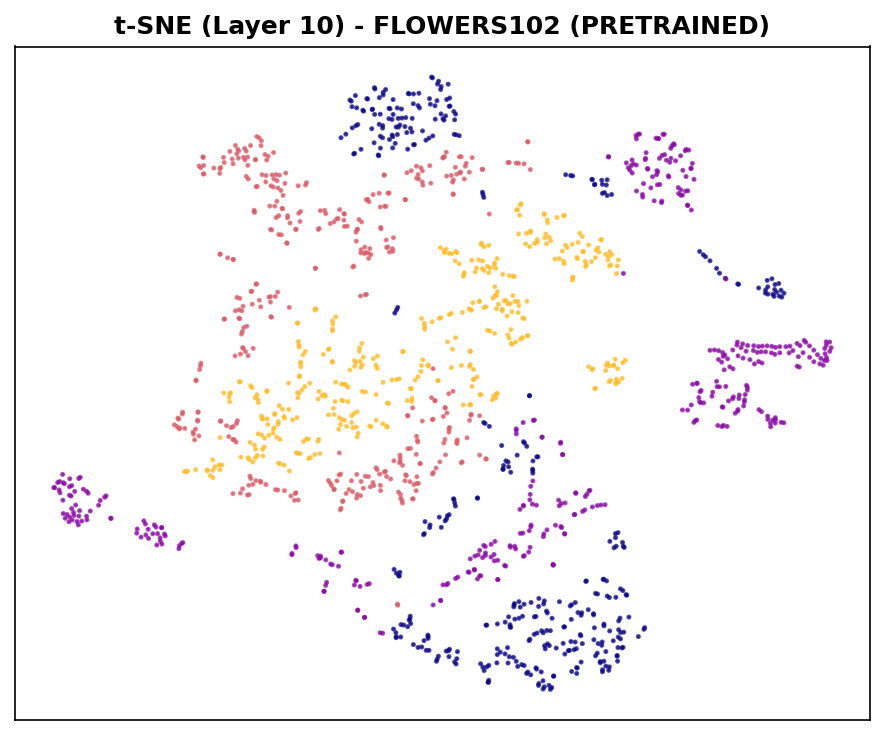

In [28]:
# Cell: t-SNE Analysis - Fixed with Better Error Handling
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

def visualize_token_tsne(ax, zs, depth, ys, title="", cmap=cm.get_cmap("plasma")): 
    if depth >= len(zs) or zs[depth] is None:
        ax.text(0.5, 0.5, "No data available", ha='center', va='center', transform=ax.transAxes)
        return
    
    latents = zs[depth]
    print(f"t-SNE input shape: {latents.shape}")
    
    latents = latents[:,1:,:]  # drop cls
    latents = rearrange(latents, "b n c -> (b n) c")
    latents = latents.cpu()
    
    print(f"t-SNE latents shape after reshape: {latents.shape}")

    # Ensure we have enough samples for t-SNE
    min_samples = 30
    if latents.shape[0] < min_samples:
        ax.text(0.5, 0.5, f"Not enough samples for t-SNE\n(need {min_samples}, got {latents.shape[0]})", 
                ha='center', va='center', transform=ax.transAxes)
        return

    perplexity = min(20, latents.shape[0]//3)
    reducer = TSNE(n_components=2, perplexity=perplexity, 
                   learning_rate='auto', init='random', n_iter=1000)
    embedded = reducer.fit_transform(latents)
    
    labels = ys.cpu().numpy() if torch.is_tensor(ys) else ys
    labels = np.array([[label] * (latents.shape[0]//len(labels)) for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=2, alpha=0.7)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks([])
    ax.set_yticks([])

# Run t-SNE analysis with better error handling
if wrapped_model is not None and dataset_test is not None:
    print(f"Running t-SNE Analysis for {DATASET}_{METHOD}...")
    
    try:
        # Get first batch
        xs, ys = next(iter(dataset_test))
        print(f"Got batch - xs: {xs.shape}, ys: {len(ys)}")
        
        with torch.no_grad():
            xs = xs.cuda()
            _, zs, _, _ = wrapped_model.forward_analysis(xs)
            zs = [z for z in zs[:-1] if z is not None]  # Remove final layer and filter None
        
        print(f"Valid layers for t-SNE: {len(zs)}")
        
        if zs:
            depth = min(10, len(zs)-1)  # Use layer 10 or the last available layer
            print(f"Using layer {depth}")
            
            fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=150)
            title = f"t-SNE (Layer {depth}) - {DATASET.upper()} ({METHOD.upper()})"
            visualize_token_tsne(ax, zs, depth=depth, ys=ys, title=title)
            plt.tight_layout()
            plt.show()
        else:
            print("No valid layers for t-SNE analysis")
            
    except StopIteration:
        print("Dataset is empty - no data available for t-SNE")
    except Exception as e:
        print(f"Error in t-SNE analysis: {e}")
else:
    print("Cannot run t-SNE analysis - missing model or dataset")

🔍 Running Comparative Fourier Analysis for FLOWERS102...
Analyzing flowers102_full...
Forward pass input shape: torch.Size([8, 3, 224, 224])
Hidden states: 13 layers
   Layer 0: torch.Size([8, 197, 384])
   Layer 1: torch.Size([8, 197, 384])
   Layer 2: torch.Size([8, 197, 384])
   Layer 3: torch.Size([8, 197, 384])
   Layer 4: torch.Size([8, 197, 384])
   Layer 5: torch.Size([8, 197, 384])
   Layer 6: torch.Size([8, 197, 384])
   Layer 7: torch.Size([8, 197, 384])
   Layer 8: torch.Size([8, 197, 384])
   Layer 9: torch.Size([8, 197, 384])
   Layer 10: torch.Size([8, 197, 384])
   Layer 11: torch.Size([8, 197, 384])
   Layer 12: torch.Size([8, 197, 384])
Forward pass input shape: torch.Size([8, 3, 224, 224])
Hidden states: 13 layers
   Layer 0: torch.Size([8, 197, 384])
   Layer 1: torch.Size([8, 197, 384])
   Layer 2: torch.Size([8, 197, 384])
   Layer 3: torch.Size([8, 197, 384])
   Layer 4: torch.Size([8, 197, 384])
   Layer 5: torch.Size([8, 197, 384])
   Layer 6: torch.Size([8, 19

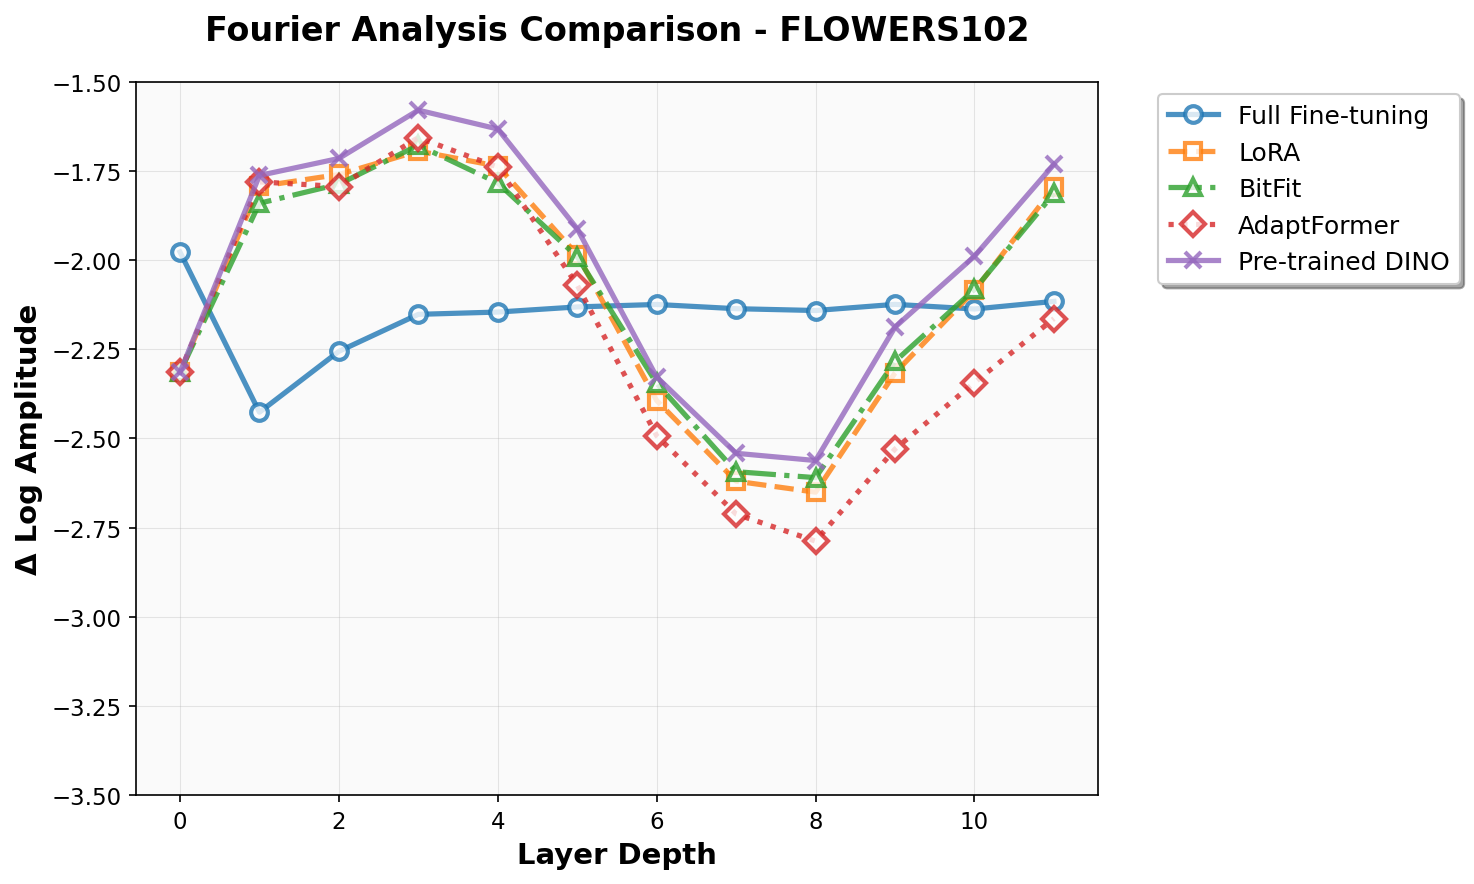


Summary Statistics:
Full Fine-tuning | Mean: -2.156 | Std: 0.100 | Min: -2.427 | Max: -1.977
LoRA            | Mean: -2.096 | Std: 0.337 | Min: -2.651 | Max: -1.695
BitFit          | Mean: -2.094 | Std: 0.314 | Min: -2.610 | Max: -1.678
AdaptFormer     | Mean: -2.199 | Std: 0.377 | Min: -2.788 | Max: -1.657
Pre-trained DINO | Mean: -2.022 | Std: 0.338 | Min: -2.562 | Max: -1.580


In [ ]:
# Cell: Comparative Fourier Analysis - All Models
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter
import numpy as np

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        
        if h * w != n:
            print(f"Non-square patch arrangement: {n} patches, expecting {h}x{w}={h*w}")
            continue
            
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]
        latent = latent - latent[0]
        fourier_latents.append(latent)
    return fourier_latents

def analyze_model_fourier(model, dataset_loader, model_name, max_batches=3):
    """Analyze Fourier characteristics for a single model"""
    print(f"Analyzing {model_name}...")
    
    fourier_latents = AverageMeter()
    batch_count = 0
    
    wrapped_model = create_analysis_wrapper(model)
    
    for i, (xs, ys) in enumerate(dataset_loader):
        try:
            with torch.no_grad():
                xs = xs.cuda()
                _, zs, _, _ = wrapped_model.forward_analysis(xs)
                
            # Remove final classification layer and filter valid layers
            valid_zs = [z for z in zs[:-1] if z is not None]
            
            if valid_zs:
                # Remove CLS token
                latents = [z[:,1:,:] for z in valid_zs]
                _fourier_latents = get_fourier_latents(latents)
                
                if _fourier_latents:
                    fourier_tensor = torch.stack(_fourier_latents)
                    fourier_latents.update(fourier_tensor)
            
            batch_count += 1
            if batch_count >= max_batches:
                break
                
        except Exception as e:
            print(f"Error processing batch {i}: {e}")
            continue
    
    if fourier_latents.count > 0:
        print(f"Collected data from {fourier_latents.count} batches")
        return fourier_latents.avg
    else:
        print(f"No valid data collected")
        return None

# Run comparative analysis if we have models and dataset
if available_models and dataset_test is not None:
    print(f"Running Comparative Fourier Analysis for {DATASET.upper()}...")
    
    # Define visual styles for each method
    method_styles = {
        'pretrained': {'marker': 'x', 'color': '#9467bd', 'linestyle': '-', 'label': 'Pre-trained DINO'},
        'full': {'marker': 'o', 'color': '#1f77b4', 'linestyle': '-', 'label': 'Full Fine-tuning'},
        'lora': {'marker': 's', 'color': '#ff7f0e', 'linestyle': '--', 'label': 'LoRA'},
        'bitfit': {'marker': '^', 'color': '#2ca02c', 'linestyle': '-.', 'label': 'BitFit'},
        'adaptformer': {'marker': 'D', 'color': '#d62728', 'linestyle': ':', 'label': 'AdaptFormer'}
    }
    
    # Collect results for all models
    results = {}
    
    for model_key, model in available_models.items():
        dataset_name, method = model_key.split('_')
        
        # Only analyze models for the current dataset
        if dataset_name == DATASET:
            fourier_avg = analyze_model_fourier(model, dataset_test, model_key)
            if fourier_avg is not None:
                results[method] = fourier_avg
    
    # Plot comparative results
    if results:
        print(f"\nPlotting comparative results...")
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
        
        for method, fourier_avg in results.items():
            style = method_styles.get(method, {'marker': 'o', 'color': 'black', 'linestyle': '-', 'label': method})
            
            x_values = range(len(fourier_avg))
            y_values = fourier_avg[:, -1].cpu().numpy()
            
            ax.plot(x_values, y_values, 
                   marker=style['marker'], 
                   color=style['color'],
                   linestyle=style['linestyle'],
                   linewidth=2.5, 
                   markersize=8,
                   markerfacecolor='white',
                   markeredgecolor=style['color'],
                   markeredgewidth=2,
                   label=style['label'],
                   alpha=0.8)
        
        # Customize the plot
        ax.set_xlabel("Layer Depth", fontsize=14, fontweight='bold')
        ax.set_ylabel("Δ Log Amplitude", fontsize=14, fontweight='bold')
        ax.set_title(f"Fourier Analysis Comparison - {DATASET.upper()}", 
                    fontsize=16, fontweight='bold', pad=20)
        
        # Add grid and legend
        ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
        ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, 
                 bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Set axis limits and styling
        ax.set_ylim(top=-1.5, bottom=-3.5)
        ax.tick_params(axis='both', which='major', labelsize=11)
        
        # Add subtle background
        ax.set_facecolor('#fafafa')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\nSummary Statistics:")
        print("=" * 50)
        for method, fourier_avg in results.items():
            final_values = fourier_avg[:, -1].cpu().numpy()
            print(f"{method_styles[method]['label']:15} | "
                  f"Mean: {final_values.mean():.3f} | "
                  f"Std: {final_values.std():.3f} | "
                  f"Min: {final_values.min():.3f} | "
                  f"Max: {final_values.max():.3f}")
        
    else:
        print("No valid results collected for comparison")
        
else:
    print("Cannot run comparative analysis - missing models or dataset")
    print(f"Available models: {list(available_models.keys()) if available_models else 'None'}")
    print(f"Dataset available: {dataset_test is not None}")